In [1]:
!pip install torch
!pip install pillow
!pip install numpy
!pip install torchvision
!pip install matplotlib

In [3]:
from torch import nn
from torch.nn import functional as F
import torch.backends.cudnn as cudnn

from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.utils.data import Sampler
from torchvision.transforms import (Compose, RandomCrop, ToTensor,
                                    ToPILImage, CenterCrop, Resize, Normalize, Lambda)

import torch
import torchvision
import math
import numpy as np
from glob import glob

from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision.transforms import (
    Compose, RandomCrop, ToTensor,
    ToPILImage, CenterCrop, Resize,
    RandomHorizontalFlip, RandomVerticalFlip)
from pathlib import Path
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import os
from torch.cuda.amp import GradScaler

In [4]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

## Model

In [5]:
class ResidualBlock(nn.Module):
    """
    At the core of our very deep generator network G, which
    is illustrated in Figure 4 are B residual blocks with identical
    layout. Inspired by Johnson et al. [33] we employ the block
    layout proposed by Gross and Wilber [24]. Specifically, we
    use two convolutional layers with small 3×3 kernels and 64
    feature maps followed by batch-normalization layers [32]
    and ParametricReLU [28] as the activation function.

    k3n64s1 => 
        kernel_size = 3,
        channels = 64,
        stride = 1
    """
    
    def __init__(self, channels=64, kernel_size=3, stride=1):
        super().__init__()
        padding = 3 // 2
        self.conv1 = nn.Conv2d(in_channels=channels,
                            out_channels=channels,
                            kernel_size=kernel_size,
                            padding=padding,
                            stride=stride)
        self.bn1 = nn.BatchNorm2d(num_features=channels)
        self.prelu = nn.PReLU()

        self.conv2 = nn.Conv2d(in_channels=channels,
                            out_channels=channels,
                            kernel_size=kernel_size,
                            padding=padding,
                            stride=stride)
        self.bn2 = nn.BatchNorm2d(num_features=channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        # Element-wise sum
        return residual + x

class SPCNBlock(nn.Module):
    """
    SPCN - sub-pixel convolutional neural network
    We increase the resolution of the input image with two trained
    sub-pixel convolution layers as proposed by Shi et al. [48].

    https://arxiv.org/pdf/1609.05158.pdf

    k3n256s1 => 
        kernel_size = 3,
        channels = 256, (64 * (2 ** 2))
        stride = 1
    """
    def __init__(self, in_channels, 
                upscale_factor=2,
                kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                            out_channels=in_channels * (upscale_factor ** 2),
                            kernel_size=kernel_size,
                            padding=kernel_size // 2)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=upscale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)

        return x

In [6]:
class ConvolutionalBlock(nn.Module):
    """
    Convolutional block has convolutional, Batch Normalization and activation layers.
    It supports 3 types of activation: PReLU, LeakyReLU and Tanh
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, batch_norm=False, activation=None):
        super(ConvolutionalBlock, self).__init__()

        if activation is not None:
            activation = activation.lower()
            assert activation in {'prelu', 'leakyrelu', 'tanh'}

        layers = list()

        layers.append(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2))

        if batch_norm is True:
            layers.append(nn.BatchNorm2d(num_features=out_channels))

        if activation == 'prelu':
            layers.append(nn.PReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU(0.2))
        elif activation == 'tanh':
            layers.append(nn.Tanh())

        self.conv_block = nn.Sequential(*layers)

    def forward(self, input):
        output = self.conv_block(input)

        return output


class SRResNet(nn.Module):
    """
    The SRResNet, as defined in the paper.
    """

    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between i.e, the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(SRResNet, self).__init__()

        self.conv_block1 = ConvolutionalBlock(in_channels=3, out_channels=n_channels, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='PReLu')

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(channels=n_channels) for i in range(n_blocks)])

        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels,
                                              kernel_size=small_kernel_size,
                                              batch_norm=True, activation=None)

        n_SPCNblocks = int(math.log2(scaling_factor))
        self.SPCNblocks = nn.Sequential(
            *[SPCNBlock(in_channels=n_channels, upscale_factor=2, kernel_size=small_kernel_size) for i
              in range(n_SPCNblocks)])

        self.conv_block3 = ConvolutionalBlock(in_channels=n_channels, out_channels=3, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='Tanh')

    def forward(self, lr_imgs):
        output = self.conv_block1(lr_imgs)
        residual = output 
        output = self.residual_blocks(output)  
        output = self.conv_block2(output) 
        output = output + residual 
        output = self.SPCNblocks(output)  
        sr_imgs = self.conv_block3(output)  
        return sr_imgs
        

In [7]:
scaling_factor = 4 
large_kernel_size = 9  
small_kernel_size = 3  
n_channels = 64  
n_blocks = 16
batch_size = 16  
workers = 4 
lr = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model = SRResNet(large_kernel_size=large_kernel_size, small_kernel_size=small_kernel_size,
                  n_channels=n_channels, n_blocks=n_blocks, scaling_factor=scaling_factor)

optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()),
                              lr=lr)


model = model.to(device)
model

SRResNet(
  (conv_block1): ConvolutionalBlock(
    (conv_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (1): PReLU(num_parameters=1)
    )
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1

In [9]:
sum(param.numel() for param in model.parameters())

1549462

## Data preprocessing and Dataset

In [10]:
def max_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

mean =  torch.FloatTensor([0.485, 0.456, 0.406])
std =  torch.FloatTensor([0.229, 0.224, 0.225])

img_mean = mean.view([3, 1, 1])
img_std = std.view([3, 1, 1])
batch_mean = mean.view([1, 3, 1, 1])
batch_std = std.view([1, 3, 1, 1])

# normalize = Normalize(mean=mean,
#                       std=std)

def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor(),
        Lambda(imagenet_normalise),
    ])

def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor(),
        # normalize
    ])

def valid_hr_transform():
    return Compose([
        ToTensor(),
    ])

def valid_lr_transform(crop_size):
    return Compose([
        ToPILImage(),
        Resize(crop_size, interpolation=Image.BICUBIC),
        ToTensor(),
        Lambda(imagenet_normalise),
    ])

output_to_pil_image = Compose(
    [
     # add 1          => [0, 2]
     # divide by 2    => [0, 1]
     Lambda(lambda img: (img + 1.0) / 2.0),
     ToPILImage()
    ]
)

def imagenet_normalise(img):
    input_device = img.device
    if img.ndimension() == 3:
        img = (img - img_mean.to(input_device)) / img_std.to(input_device)
    elif img.ndimension() == 4:
        img = (img - batch_mean.to(input_device)) / batch_std.to(input_device)
    return img

output_to_imagenet = Compose(
    [
     # add 1          => [0, 2]
     # divide by 2    => [0, 1]
     Lambda(lambda img: (img + 1.0) / 2.0),
     Lambda(imagenet_normalise),
    ]
)

class SRImageDataset(Dataset):
    def __init__(self, dataset_dir, 
                 crop_size=100, 
                 upscale_factor=4, is_valid=False):
        super().__init__()
        glob_path = str(Path(dataset_dir) / "*[.jpg, .png]")
        self.crop_size = max_crop_size(crop_size, upscale_factor)
        self.upscale_factor = upscale_factor
        
        self.image_filenames = glob(glob_path)
        self.is_valid = is_valid

    def __getitem__(self, index):
        pil_hr_image = Image.open(self.image_filenames[index])
        if self.is_valid:
            hr_image = valid_hr_transform()(pil_hr_image)
            crop_size = (int(pil_hr_image.height / 4),
                         int(pil_hr_image.width / 4))
            lr_image = valid_lr_transform(crop_size)(hr_image)
        else:
            hr_image = train_hr_transform(self.crop_size)(pil_hr_image)
            lr_image = train_lr_transform(self.crop_size, self.upscale_factor)(hr_image)
        
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [11]:
train_dataset = SRImageDataset(
    dataset_dir="data/train_data/",  #sr/DIV2K_train_HR
    crop_size=32
)

valid_dataset = SRImageDataset(
    dataset_dir="data/valid_data/", #sr/DIV2K_valid_HR
    crop_size=500
)

In [12]:
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=200,
    num_workers=4
)
valid_dataloader = DataLoader(
    dataset=valid_dataset, batch_size=10,
    num_workers=4
)

len(train_dataloader), len(valid_dataloader) 

(15, 10)

## Training loop

In [13]:
def save_checkpoint(model, filepath):
    
    checkpoint = {'state_dict': model.state_dict()}

    torch.save(checkpoint, filepath)



def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = SRResNet(large_kernel_size=large_kernel_size, small_kernel_size=small_kernel_size,
                  n_channels=n_channels, n_blocks=n_blocks, scaling_factor=scaling_factor)
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)

    return model

In [14]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [15]:
#load_model(model, 'models/model_loss_23.pth')

filepath = "checkpoints/checkpoint.pth"
os.makedirs("checkpoints", exist_ok=True)
model = load_checkpoint(filepath)

PATH = Path("models")

In [16]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations, div_start=5, div_end=5):
    min_start, min_end = max_lr/div_start, max_lr/div_end
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [22]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    y_hat = []
    ys = []
    for lr, hr in valid_dl:
        lr, hr = lr.to(device), hr.to(device)
        batch = hr.shape[0]
        out = model(lr) #.cuda()
        loss = F.mse_loss(out*255, hr*255) #.cuda()
        sum_loss += batch*(loss.item())
        total += batch

    return sum_loss/total

def train_model(model, train_dl, valid_dl, optimizer,
                max_lr=0.05, epochs=100,
                save_freq=5, filepath=filepath,
                is_amp=False):
    iterations = epochs * len(train_dl)
    pbar = tqdm(total=iterations)
    idx = 0
    best_val_r2 = 0

    # scaler = GradScaler()  

    for t in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        for lr, hr in train_dl:
            lr, hr = lr.to(device), hr.to(device)
            batch_size = hr.size(0)
            sr = model(lr)
            sr = output_to_imagenet(sr)
            loss = F.mse_loss(sr*255, hr*255)
            optimizer.zero_grad()
            
            loss.backward()
            # scaler.scale(loss).backward()
            # with amp.scale_loss(loss, optimizer) as scaled_loss:
                # scaled_loss.backward()
            optimizer.step()
            
            # optimizer.step()
            # scaler.step(optimizer)
            
            total_loss += loss.item() * batch_size
            total += batch_size
            idx +=1
            pbar.update()
            
            # Updates the scale for next iteration
            # scaler.update()
            del lr, hr, sr
        
        # val_loss = val_metrics(model, valid_dl)

        if t % save_freq == 0:
            save_checkpoint(model, filepath)
            print(f"Training Loss: {total_loss/total}")
        # print(f"Training Loss: {total_loss/total}, Valid Loss: {val_loss}")
            
    return 0

In [20]:
#lr = 0.01 with 16blocks
train_model(model, train_dataloader, valid_dataloader, optimizer, epochs=100)

Training Loss: 4.911146023694207
Training Loss: 4.862903284425495
Training Loss: 5.051706805616534
Training Loss: 4.828947508034586
Training Loss: 4.866860404401934
Training Loss: 4.889155858037185
Training Loss: 4.897463968154095
Training Loss: 4.840359321829317
Training Loss: 4.854372120704971
Training Loss: 4.909138867835037
Training Loss: 4.926257321814529
Training Loss: 4.9255418804179385
Training Loss: 4.829954784457423
Training Loss: 4.888429349210082
Training Loss: 4.911935119735761
Training Loss: 4.946120451812317
Training Loss: 4.969252671848158
Training Loss: 4.910281073145506
Training Loss: 4.757934723915506
Training Loss: 4.920112454924597
Training Loss: 4.910975222494088
Training Loss: 4.875583405588188
Training Loss: 4.836654164877927
Training Loss: 4.919559345191934
Training Loss: 4.8617089108592655
Training Loss: 4.930336729819033
Training Loss: 4.913171056271935
Training Loss: 4.998335493712866
Training Loss: 4.89109423314156
Training Loss: 4.907405602163961
Training 

0

In [23]:
#lr = 0.01 with 16blocks
train_model(model, train_dataloader, valid_dataloader, optimizer, epochs=500)

KeyboardInterrupt: 

In [34]:
os.makedirs(PATH, exist_ok=True)
save_checkpoint(model, filepath)

## Evaluate model

In [19]:
example, hr = valid_dataset[9]
model.eval()
out = model(example.unsqueeze(0).to(device)).to("cpu").squeeze(0)
F.mse_loss(out, hr)

tensor(2.9844, grad_fn=<MseLossBackward>)

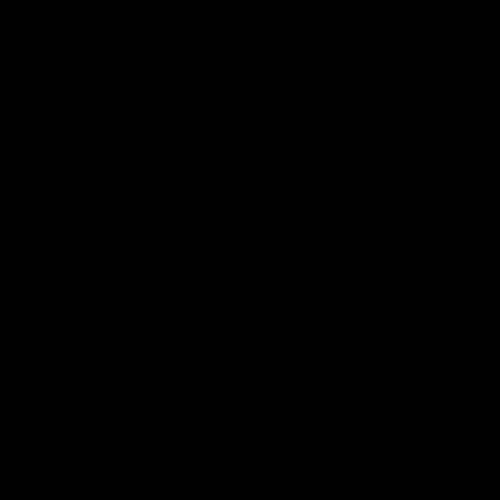

In [21]:
ToPILImage()(out)

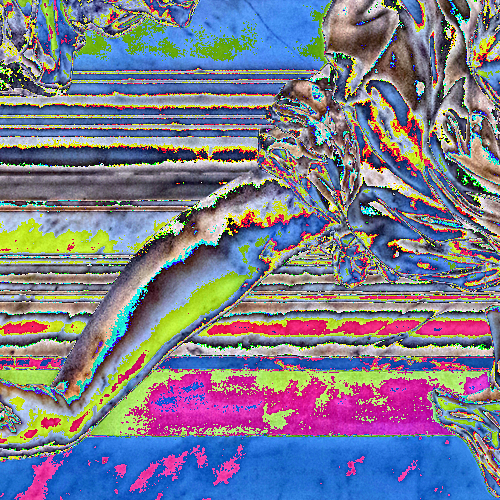

In [25]:
ToPILImage()(hr)

In [26]:
lr, hr = train_dataset[100]

In [27]:
ToPILImage()(lr)

In [28]:
model.eval()
out = model(lr.unsqueeze(0).to(device)).to("cpu").squeeze(0)
F.mse_loss(out, hr)

tensor(1.0639, grad_fn=<MseLossBackward>)

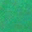

In [29]:
ToPILImage()(hr)

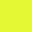

In [30]:
ToPILImage()(output_to_imagenet(out))